# 03 - Model Training (ResNet-LSTM)

This notebook trains a video classification model to detect myocardial infarction (MI) using echocardiographic frames from A4C or A2C views.

We use:
- ResNet18 for feature extraction
- LSTM for temporal sequence modeling
- Attention for weighted frame importance

The model is trained using extracted frame folders created in previous steps.
 Curves


In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, models
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F

from myutils import get_frames, store_frames, plot_loss, train_val

# Set seed for reproducibility
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")




In [2]:
# Change 'A4C' to 'A2C' to train on the other view
view = "A4C"

# Input video JPG directories
train_dir = f"./data/{view}_jpg_training"
val_dir   = f"./data/{view}_jpg_validation"
test_dir  = f"./data/{view}_jpg_test"

# Frame count per video
timesteps = 16


In [3]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])


In [4]:
from glob import glob
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform, split="training"):
        self.ids = ids
        self.labels = labels
        self.transform = transform
        self.timesteps = timesteps
        self.folder_map = {
            "training": f"{view}_jpg_training",
            "validation": f"{view}_jpg_validation",
            "test": f"{view}_jpg_test"
        }
        self.split = split

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        base_path = self.ids[idx].replace(view, self.folder_map[self.split]).replace(".avi", "")
        frame_paths = sorted(glob(os.path.join(base_path, "*.jpg")))[:self.timesteps]
        frames = [self.transform(Image.open(p).convert("RGB")) for p in frame_paths]
        return torch.stack(frames), self.labels[idx]


In [5]:
# Assume these are defined already from preprocessing notebook (or reimport them)
import pickle

with open("a4c_video_splits.pkl", "rb") as f:
    splits = pickle.load(f)

train_videos = splits["train_videos"]
train_labels = splits["train_labels"]
val_videos = splits["val_videos"]
val_labels = splits["val_labels"]

train_ds = VideoDataset(train_videos, train_labels, train_transform, "training")
val_ds   = VideoDataset(val_videos, val_labels, eval_transform, "validation")

def collate_fn(batch):
    xb, yb = zip(*batch)
    return torch.stack(xb), torch.tensor(yb)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_dl   = DataLoader(val_ds, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [6]:
class Identity(nn.Module):
    def forward(self, x):
        return x

class Resnt18Rnn(nn.Module):
    def __init__(self, params_model):
        super().__init__()
        num_classes = params_model["num_classes"]
        dr_rate = params_model["dr_rate"]
        rnn_hidden_size = params_model["rnn_hidden_size"]
        rnn_num_layers = params_model["rnn_num_layers"]

        baseModel = models.resnet18(pretrained=True)
        baseModel.fc = Identity()
        self.baseModel = baseModel
        self.rnn = nn.LSTM(512, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.dropout = nn.Dropout(dr_rate)
        self.fc1 = nn.Linear(rnn_hidden_size, num_classes)

        self.attn = nn.Linear(rnn_hidden_size * 2, rnn_hidden_size)
        self.v = nn.Linear(rnn_hidden_size, 1, bias=False)

    def forward(self, x):
        b, t, c, h, w = x.shape
        outputs = []

        y = self.baseModel(x[:, 0])
        rnn_out, (hn, cn) = self.rnn(y.unsqueeze(1))
        outputs.append(rnn_out)

        for i in range(1, t):
            y = self.baseModel(x[:, i])
            out, (hn, cn) = self.rnn(y.unsqueeze(1), (hn, cn))
            outputs.append(out)

        outputs = torch.cat(outputs, dim=1)  # [B, T, H]
        query = self.dropout(out[:, -1])

        hidden = query.unsqueeze(1).repeat(1, outputs.size(1), 1)
        energy = torch.tanh(self.attn(torch.cat((hidden, outputs), dim=2)))
        attention = F.softmax(self.v(energy).squeeze(2), dim=1)
        weighted = torch.bmm(attention.unsqueeze(1), outputs).squeeze(1)
        return self.fc1(weighted)


In [8]:

params_model = {
    "num_classes": 2,
    "dr_rate": 0.3,
    "rnn_hidden_size": 100,
    "rnn_num_layers": 1
}

model = Resnt18Rnn(params_model).to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=5)

params_train = {
    "num_epochs": 50,
    "optimizer": optimizer,
    "loss_func": loss_func,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": False,
    "lr_scheduler": scheduler,
    "path2weights": f"../models/weights_{view.lower()}_rnn.pt",
}

model, loss_hist, metric_hist = train_val(model, params_train)


Epoch 0/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.026571, dev loss: 0.040616, accuracy: 76.92
----------
Epoch 1/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.019915, dev loss: 0.033065, accuracy: 92.31
----------
Epoch 2/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.014819, dev loss: 0.029322, accuracy: 84.62
----------
Epoch 3/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.014010, dev loss: 0.018093, accuracy: 100.00
----------
Epoch 4/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.012472, dev loss: 0.017863, accuracy: 92.31
----------
Epoch 5/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.007644, dev loss: 0.024397, accuracy: 92.31
----------
Epoch 6/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.007392, dev loss: 0.031198, accuracy: 69.23
----------
Epoch 7/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.004880, dev loss: 0.028879, accuracy: 84.62
----------
Epoch 8/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.003527, dev loss: 0.010499, accuracy: 100.00
----------
Epoch 9/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.005352, dev loss: 0.018667, accuracy: 84.62
----------
Epoch 10/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.007080, dev loss: 0.050880, accuracy: 76.92
----------
Epoch 11/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.003497, dev loss: 0.005613, accuracy: 100.00
----------
Epoch 12/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.017016, dev loss: 0.043119, accuracy: 61.54
----------
Epoch 13/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002889, dev loss: 0.005605, accuracy: 100.00
----------
Epoch 14/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002502, dev loss: 0.004090, accuracy: 100.00
----------
Epoch 15/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.003514, dev loss: 0.006819, accuracy: 100.00
----------
Epoch 16/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001363, dev loss: 0.011938, accuracy: 92.31
----------
Epoch 17/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.016639, dev loss: 0.018292, accuracy: 92.31
----------
Epoch 18/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.005889, dev loss: 0.007910, accuracy: 92.31
----------
Epoch 19/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.005749, dev loss: 0.013719, accuracy: 84.62
----------
Epoch 20/49, current lr=0.0001


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loading best model weights!
train loss: 0.003450, dev loss: 0.020524, accuracy: 92.31
----------
Epoch 21/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002771, dev loss: 0.018192, accuracy: 92.31
----------
Epoch 22/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002281, dev loss: 0.023456, accuracy: 84.62
----------
Epoch 23/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001762, dev loss: 0.014632, accuracy: 92.31
----------
Epoch 24/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.003169, dev loss: 0.031400, accuracy: 84.62
----------
Epoch 25/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001452, dev loss: 0.033970, accuracy: 84.62
----------
Epoch 26/49, current lr=5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loading best model weights!
train loss: 0.006215, dev loss: 0.073579, accuracy: 76.92
----------
Epoch 27/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001670, dev loss: 0.015374, accuracy: 92.31
----------
Epoch 28/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.007172, dev loss: 0.011634, accuracy: 92.31
----------
Epoch 29/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001410, dev loss: 0.007025, accuracy: 100.00
----------
Epoch 30/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.010264, dev loss: 0.019013, accuracy: 92.31
----------
Epoch 31/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001432, dev loss: 0.031926, accuracy: 76.92
----------
Epoch 32/49, current lr=2.5e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loading best model weights!
train loss: 0.009735, dev loss: 0.017420, accuracy: 92.31
----------
Epoch 33/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.004036, dev loss: 0.005268, accuracy: 100.00
----------
Epoch 34/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002201, dev loss: 0.009002, accuracy: 92.31
----------
Epoch 35/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002002, dev loss: 0.003876, accuracy: 100.00
----------
Epoch 36/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002159, dev loss: 0.006270, accuracy: 100.00
----------
Epoch 37/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.006573, dev loss: 0.032996, accuracy: 76.92
----------
Epoch 38/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.003682, dev loss: 0.008071, accuracy: 100.00
----------
Epoch 39/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001822, dev loss: 0.006990, accuracy: 100.00
----------
Epoch 40/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.003146, dev loss: 0.005808, accuracy: 100.00
----------
Epoch 41/49, current lr=1.25e-05


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Loading best model weights!
train loss: 0.002115, dev loss: 0.010992, accuracy: 92.31
----------
Epoch 42/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.003564, dev loss: 0.012157, accuracy: 84.62
----------
Epoch 43/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.007228, dev loss: 0.028618, accuracy: 76.92
----------
Epoch 44/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.002765, dev loss: 0.003208, accuracy: 100.00
----------
Epoch 45/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002144, dev loss: 0.017211, accuracy: 92.31
----------
Epoch 46/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.002003, dev loss: 0.006996, accuracy: 100.00
----------
Epoch 47/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001750, dev loss: 0.004580, accuracy: 100.00
----------
Epoch 48/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Copied best model weights!
train loss: 0.001855, dev loss: 0.002907, accuracy: 100.00
----------
Epoch 49/49, current lr=6.25e-06


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

train loss: 0.001655, dev loss: 0.005877, accuracy: 100.00
----------


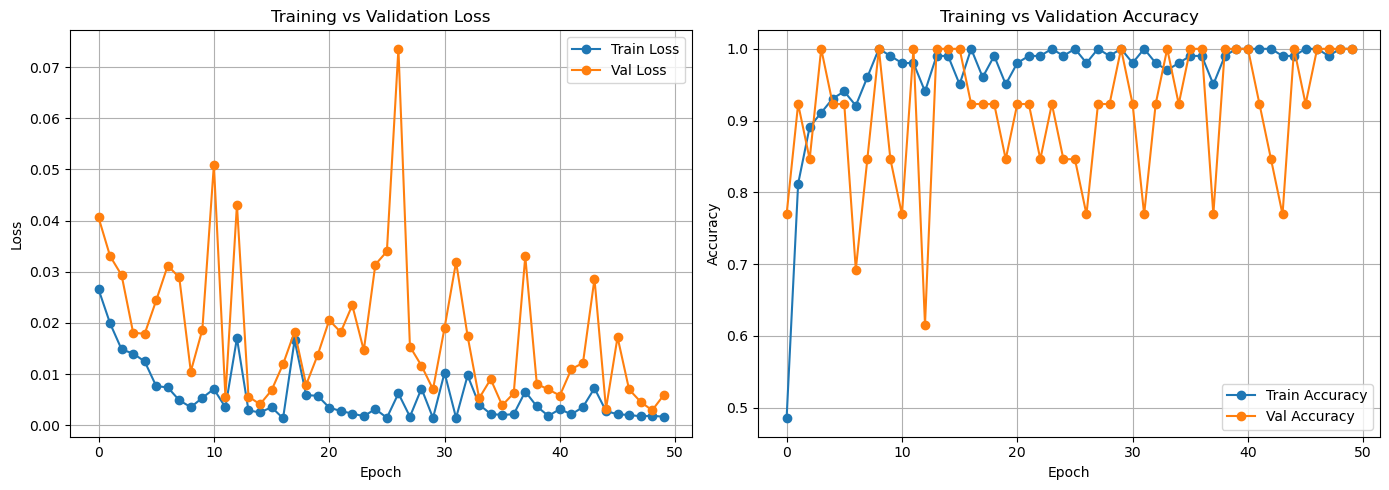

In [13]:
plt.figure(figsize=(14, 5))

# --- Plot Loss ---
plt.subplot(1, 2, 1)
plt.plot(loss_hist["train"], label="Train Loss", marker='o')
plt.plot(loss_hist["val"], label="Val Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# --- Plot Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(metric_hist["train"], label="Train Accuracy", marker='o')
plt.plot(metric_hist["val"], label="Val Accuracy", marker='o')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
